## Introduction

In the given notebook, I decided to conduct a exploratory data analysis on the results of different matches in FIFA Cup. 
The approach I went for was performing clustering on the data to see if the team perform similarly regardless of the 
team they're playing against. I perform this clustering under the assumption that the statistics provided in the dataset
are a measure of the performance of the team.

## Analysis Steps

The steps performed in this analysis:

* Reading Data
* Feature Engineering
    * Finding Missing Values
    * Categorical Encoding
    * Feature Correlation (Barplot, Heatmap)
* Kmeans, PCA and t-SNE
    * Finding the optimal number of clusters (Elbow Method)
* Plotting the clusters
    * using annotations for different teams
    * using colours for different clusters
    * using cluster centers to determine variance between clusters


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Reading Data

In [2]:
data = pd.read_csv("FIFA 2018 Statistics.csv")

Reading the data to see all the features currently available in it

In [3]:
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


## Feature Engineering

In [4]:
data.columns

Index(['Date', 'Team', 'Opponent', 'Goal Scored', 'Ball Possession %',
       'Attempts', 'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides',
       'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes',
       'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card',
       'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')

In [5]:
data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match           object
1st Goal                  float64
Round                      object
PSO                        object
Goals in PSO                int64
Own goals                 float64
Own goal Time             float64
dtype: object

### Find Missing Values

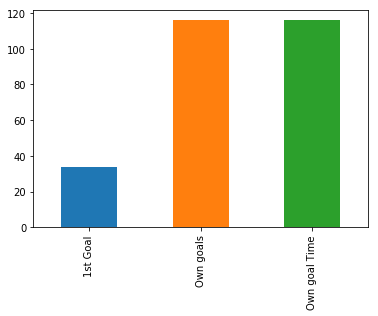

In [10]:
# checking how many missing values are present in each of the columns
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Three of the columns above seem to have a lot of missing values and may not be useful for the analysis

Based on the column types, all the features are divided into quantitative and qualitative features

In [6]:
# add features to quant list if they are int or float type
quant = [f for f in data.columns if data.dtypes[f]!='object']
# add features to qualitative list if they are object type
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']
quant

['Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red',
 '1st Goal',
 'Goals in PSO',
 'Own goals',
 'Own goal Time']

Removing quantitative features that may not add much value to the current analysis

In [7]:
quant.remove('Own goal Time')
quant.remove('Own goals')
quant.remove('Goals in PSO')
quant.remove('1st Goal')

In [8]:
quant

['Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red']

Removing qualitative features that may not add much value to the current analysis 

In [9]:
qualitative.remove('Date')
qualitative

['Team', 'Opponent', 'Man of the Match', 'Round', 'PSO']

### Categorical Encoding

Encoding the categorical features into numerical values in order to use them for different classifications

In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    # extracting unique values from a feature(column)
    ordering['val'] = frame[feature].unique()
    # assigning the unique values to the index of the dataframe
    ordering.index = ordering.val
    # creating a column ordering with values assinged from 1 to the number of unique values
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    # creating a dict with the unique values as keys and the corresponding 
    # numbers in the ordering column as values
    ordering = ordering['ordering'].to_dict()
    # adding the encoded values into the original dataframe within new columns for each feature 
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
# encoding all the features in the qualitative list
for q in qualitative:  
    encode(data, q)
    qual_encoded.append(q+'_E')
qual_encoded

['Team_E', 'Opponent_E', 'Man of the Match_E', 'Round_E', 'PSO_E']

In [12]:
data

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Round,PSO,Goals in PSO,Own goals,Own goal Time,Team_E,Opponent_E,Man of the Match_E,Round_E,PSO_E
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,Group Stage,No,0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,Group Stage,No,0,NaN,NaN,2.0,2.0,2.0,1.0,1.0
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,Group Stage,No,0,NaN,NaN,3.0,3.0,2.0,1.0,1.0
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,Group Stage,No,0,NaN,NaN,4.0,4.0,1.0,1.0,1.0
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,Group Stage,No,0,1.0,90.0,5.0,5.0,2.0,1.0,1.0
5,15-06-2018,Iran,Morocco,1,36,8,2,5,1,2,...,Group Stage,No,0,NaN,NaN,6.0,6.0,1.0,1.0,1.0
6,15-06-2018,Portugal,Spain,3,39,8,3,2,3,4,...,Group Stage,No,0,NaN,NaN,7.0,7.0,2.0,1.0,1.0
7,15-06-2018,Spain,Portugal,3,61,12,5,5,2,5,...,Group Stage,No,0,NaN,NaN,8.0,8.0,1.0,1.0,1.0
8,16-06-2018,France,Australia,2,51,12,5,4,3,5,...,Group Stage,No,0,NaN,NaN,9.0,9.0,1.0,1.0,1.0
9,16-06-2018,Australia,France,1,49,4,1,2,1,1,...,Group Stage,No,0,1.0,81.0,10.0,10.0,2.0,1.0,1.0


In [13]:
qual_encoded.remove('Opponent_E')

### Feature Correlation

In [19]:
# # feature importance
# print("Features Importance...")
# gain = model.feature_importance('gain')
# featureimp = pd.DataFrame({'feature':model.feature_name(), 
#                    'split':model.feature_importance('split'), 
#                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
# print(featureimp[:10])

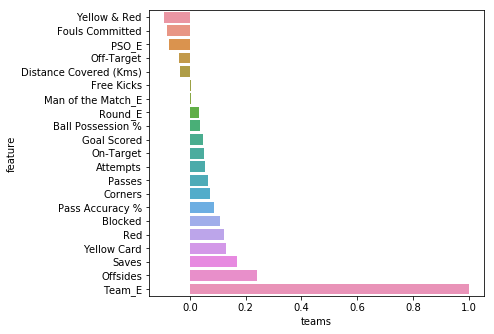

In [20]:
def feat_correlation(frame, features):
    corr = pd.DataFrame()
    corr['feature'] = features
    corr['teams'] = [frame[f].corr(frame['Team_E'], 'spearman') for f in features]
    corr = corr.sort_values('teams')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=corr, y='feature', x='teams', orient='h')
    
features = quant + qual_encoded
feat_correlation(data, features)

In [21]:
# labels = pd.DataFrame()
# x = kmeans.labels_
# labels = pd.concat([labels, pd.Series(x)])
# labels = pd.concat([labels,data['Team']],axis=1)
# labels

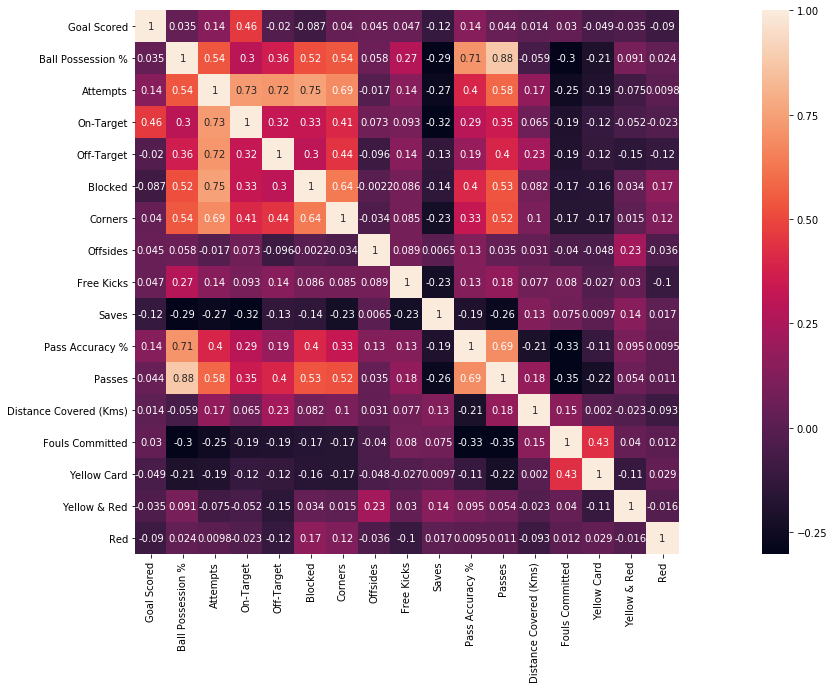

In [22]:
# plotting the heatmap for all the quantitative features to determine which features are most relevant
plt.figure(figsize=(30,10))
sns.heatmap(data[quant].corr(), square=True, annot=True,robust=True, yticklabels=1)

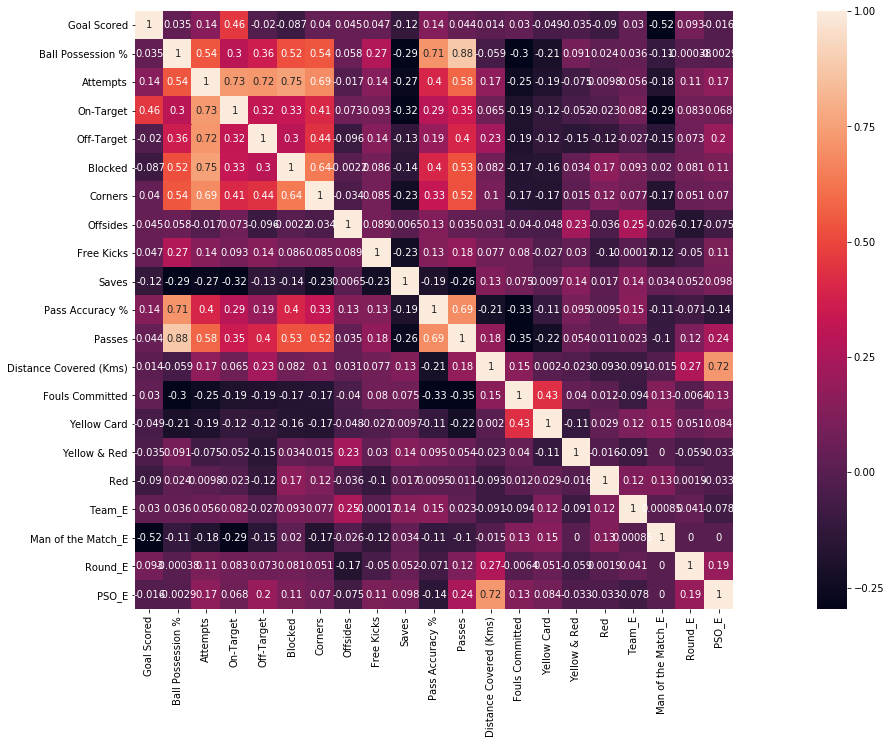

In [23]:
# plotting the heatmap for all the quantitative and qualitative features to determine which features are most relevant
plt.figure(figsize=(30,11))
sns.heatmap(data[quant+qual_encoded].corr(), square=True, annot=True,robust=True, yticklabels=1)

### KMeans and PCA

In [ ]:
# collect all the qualitative and quantitative features into one list
features = quant + qual_encoded

### Finding Optimal Number of Clusters

k:  1
k:  2


C:\Users\d847710\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


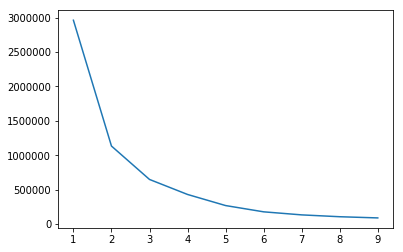

In [24]:
# Elbow criterion to determine optimal number of clusters
def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

elbow_plot(data[features], maxK=10)

Based on the graph above, 2 and 3 appear to be the optimal number of clusters

### Plotting datapoints based on team names

0.563370888518


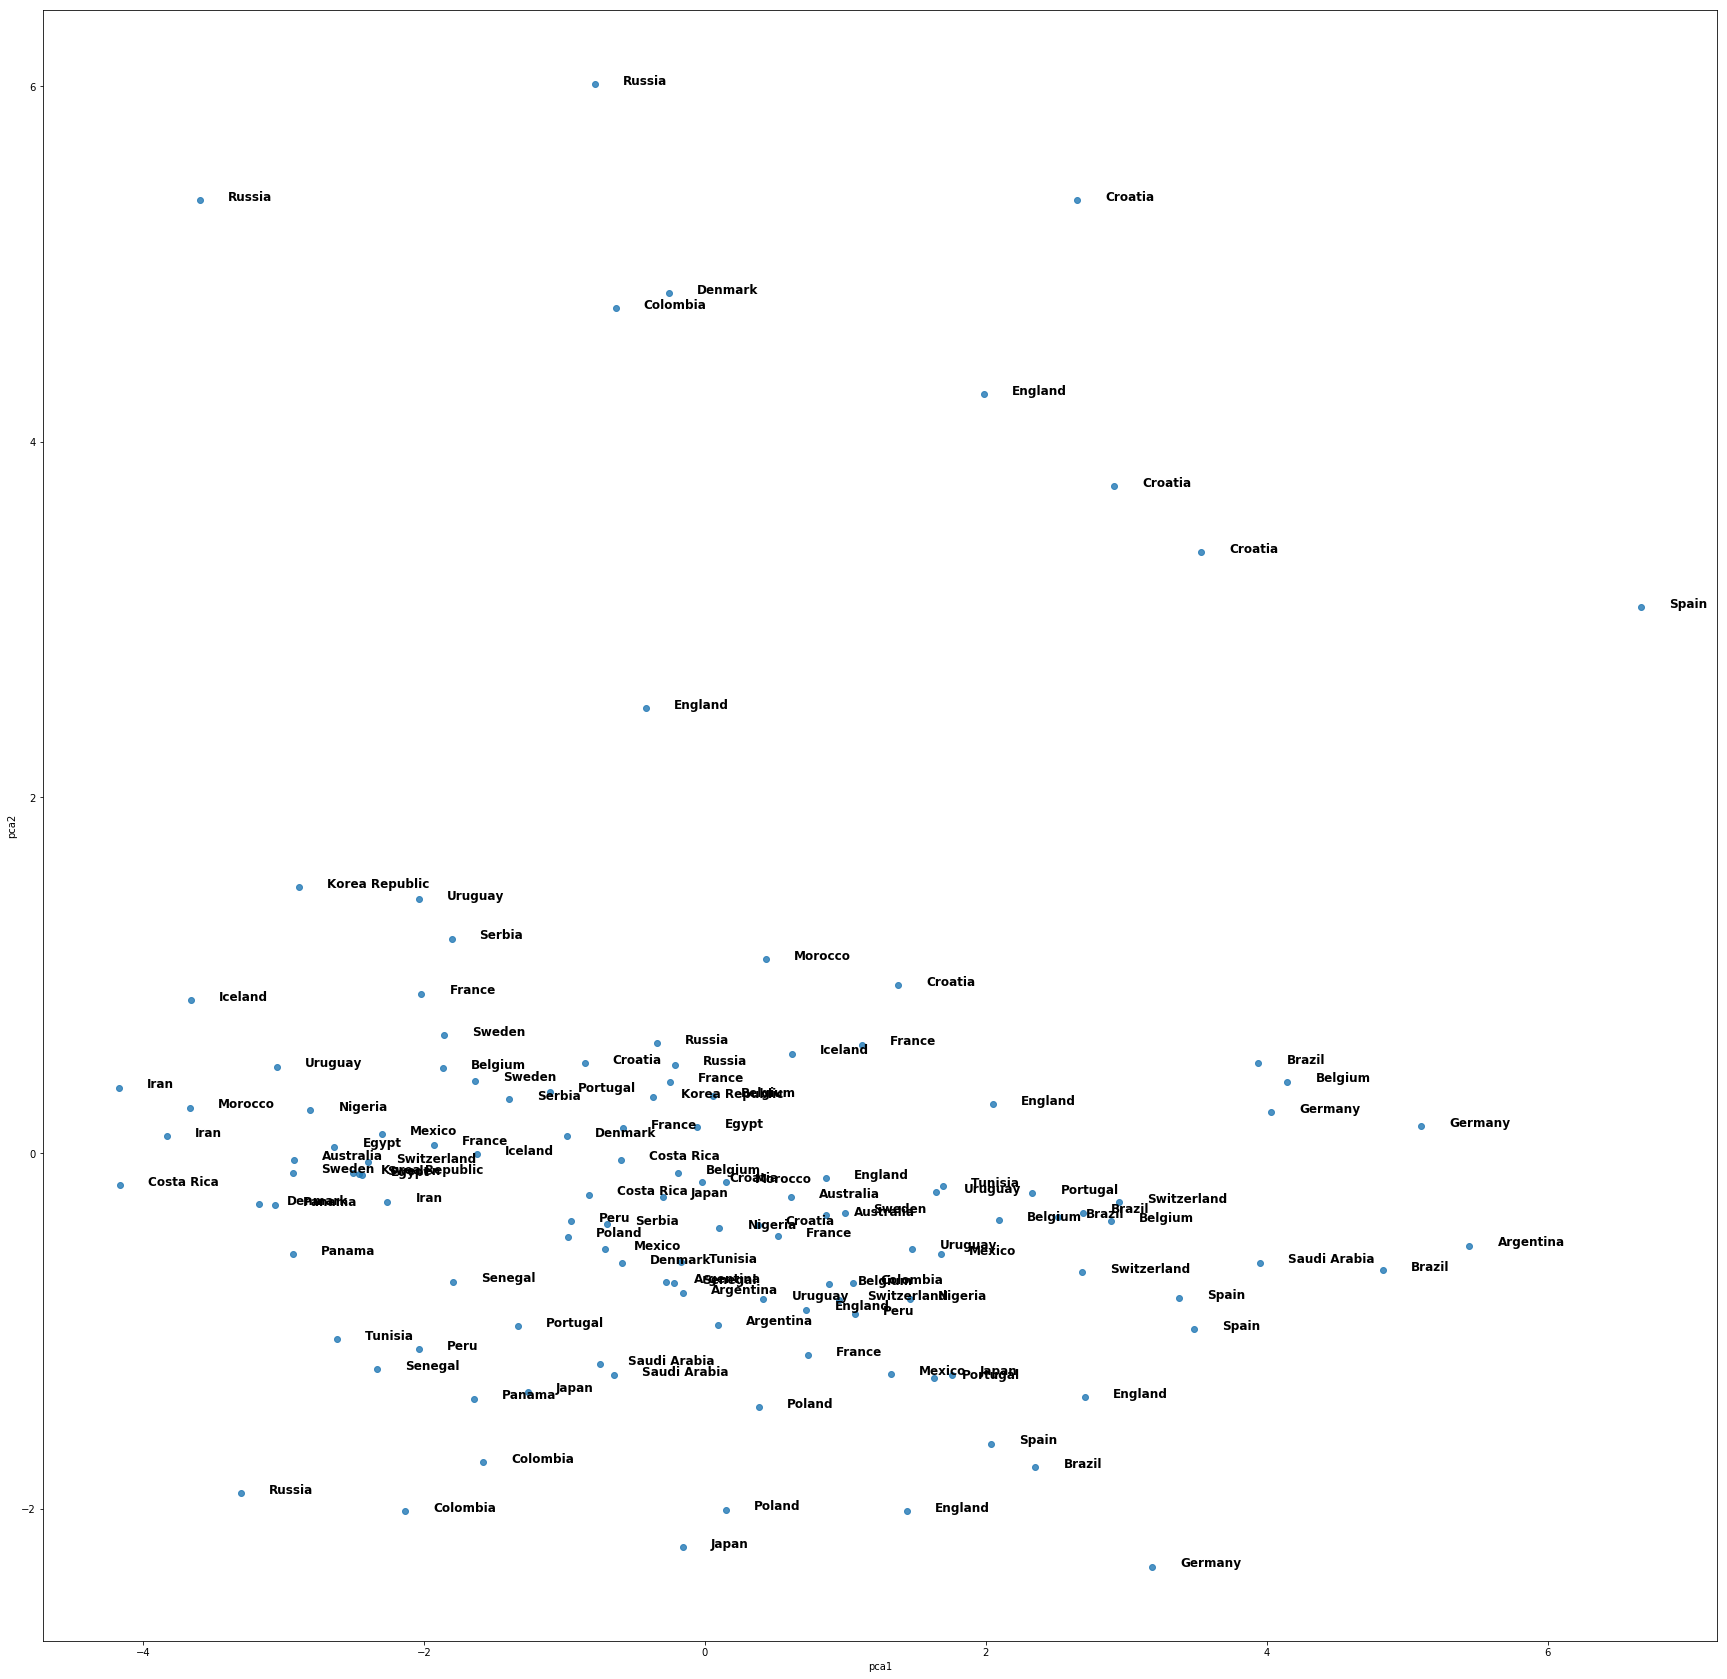

In [27]:
# reducing the dimensionality of the data to 2- dimensions using t-SNE
model = TSNE(n_components=2, random_state=0, perplexity=50)
# fill all the na values with zeros and pass all the values to X
X = data[features].fillna(0.).values
# run t-SNE on the data
tsne = model.fit_transform(X)

# standardising the data to values between 0 to 1
std = StandardScaler()
s = std.fit_transform(X)

# changing the data to 5 dimensions and fitting it into the model
pca = PCA(n_components=5)
pca.fit(s)
pc = pca.transform(s)

# fitting the data into clusters using K-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(pc)

# plotting the data points onto a figure
plt.figure(figsize=(30,30))
# fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
fr = pd.DataFrame({'pca1': pc[:,0], 'pca2': pc[:, 1], 'cluster': kmeans.labels_, 'label': data['Team']})
p1 = sns.regplot(data=fr, x='pca1', y='pca2', fit_reg=False)
# add annotations one by one with a loop
for line in range(0,fr.shape[0]):
    #uncomment this line if you wish to see points for a specific country
#     if fr.label[line]=='France':
    p1.text(fr.pca1[line]+0.2, fr.pca2[line], fr.label[line], horizontalalignment='left', size='large', color='black', weight='semibold')
print(np.sum(pca.explained_variance_ratio_)) 

### Plotting clusters based on different colour for each cluster

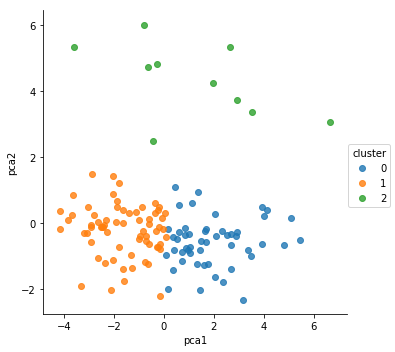

In [15]:
# lmplot used in case the clusters need to be differentiated from each other based on colour
p1 = sns.lmplot(data=fr, x='pca1', y='pca2', fit_reg=False, hue='cluster')

In [16]:
kmeans.labels_

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 2, 2, 1, 1, 0,
       1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0])

In [17]:
kmeans.cluster_centers_

array([[ 1.90703753, -0.57329138, -0.10311512, -0.10750095, -0.12217126],
       [-1.63157118, -0.20964558,  0.01606877, -0.09156997,  0.04868416],
       [ 1.20563546,  4.32841144,  0.41822635,  1.16177364,  0.29688955]])

### Plotting the cluster centers to see the variance between the clusters

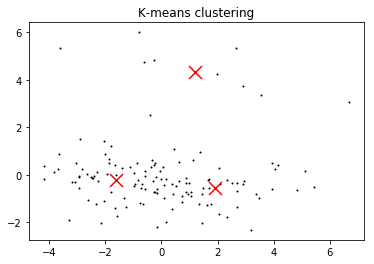

In [18]:
plt.plot(pc[:, 0], pc[:, 1], 'k.', markersize=2)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)
plt.title('K-means clustering')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()

#### References
* https://www.kaggle.com/ragnisah/extensive-eda-fifa-2018-man-of-the-match
* https://www.kaggle.com/himol7/myfifa/notebook

### Conclusion 

It appears that datapoints of the statistics of the same country falls in a similar space, regardless of who they play against, once they've been plotted. Could that mean that a lot of the countries perform the same regardless of the country they're playing against? Further exploration could potentially help answer this question.